# Human Activity Recognition with Deep Learning

### 1. Overview
- [PAMAP2 Dataset](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring)
- Human Activity Recognition using Accelerometer worn on the Wrist

<img src="images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>Figure 1. Data Samples (Walking and Sitting)</div>

#### Import Libraries

In [1]:
from collections import Counter
from glob import glob
import os
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPool2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, normalize
%matplotlib inline

from visualize import plot_confusion_matrix

### 1. Preprocessing

#### A. Same as Machine Learning

In [2]:
filepaths = sorted(glob('data/PAMAP2/*.dat'))
filepaths

['data/PAMAP2/subject101.dat',
 'data/PAMAP2/subject102.dat',
 'data/PAMAP2/subject103.dat',
 'data/PAMAP2/subject104.dat',
 'data/PAMAP2/subject105.dat',
 'data/PAMAP2/subject106.dat',
 'data/PAMAP2/subject107.dat',
 'data/PAMAP2/subject108.dat',
 'data/PAMAP2/subject109.dat']

In [3]:
time_index = 0
label_index = 1
accelerometer_indices = {
    'hand': [4, 5, 6],
    'chest': [21, 22, 23],
    'ankle': [38, 39, 40],
}

label_map = {
    1: 'lying',
    2: 'sitting',
    3: 'standing',
    4: 'walking',
    5: 'running',
    6: 'cycling',
    7: 'Nordic walking',
    9: 'watching TV',
    10: 'computer work',
    11: 'car driving',
    12: 'ascending stairs',
    13: 'descending stairs',
    16: 'vacuum cleaning',
    17: 'ironing',
    18: 'folding laundry',
    19: 'house cleaning',
    20: 'playing soccer',
    24: 'rope jumping',
    0: 'other (transient activities)',
}

In [4]:
def most_common(l):
    """
    Find most common element in the list.
    
    Parameters
    ----------
    l : list
        list to find most common element
    
    Returns
    -------
    most common element
    """
    return Counter(l).most_common(1)[0][0]


def sliding_window(data, label, window_size, stride_size):
    """
    Apply sliding window to 2D array.
    Returns array of sliding windows.
    
    Parameters
    ----------
    data : array-like of shape (n_samples, num_features)
        X samples
    
    label : array-like of shape (n_samples,)
        y samples
    
    window_size : int
        Size of single window
    
    stride_size : int
        Space between windows
    
    Returns
    -------
    sliding_windows : array-like of shape (n_windows, window_size, num_features)
        Array of sliding windows

    labels : array-like of shape (n_windows,)
        Array of labels for each sliding window
    """
    sliding_windows, labels = [], []
    
    start = 0
    end = window_size
    
    while end < data.shape[0]:
        _data = data[start: end]
        _label = most_common(label[start: end])
        
        sliding_windows.append(_data)
        labels.append(_label)
        
        start += stride_size
        end += stride_size
    
    return np.array(sliding_windows), np.array(labels)

In [5]:
sampling_rate = 100
window_size = int(1 * sampling_rate)
stride_size = int(0.5 * sampling_rate)

Xs, Ys, groups = [], [], []
for idx, filepath in enumerate(filepaths):
    # Load data
    df = pd.read_csv(filepath, delimiter=' ', header=None)

    # Select time, label, data columns
    time = df[time_index]
    label = df[label_index]
    data = df[accelerometer_indices['hand']]
    
    # Drop rows with NaN values
    data = data.dropna(axis='index')
    
    # Sliding window
    X, Y = sliding_window(data, label, window_size, stride_size)
    
    # Drop "No Activity" samples
    mask = Y != 0
    X, Y = X[mask], Y[mask]
    
    # Add to Train/Test data
    Xs.append(X)
    Ys.append(Y)
    groups.append(np.full(X.shape[0], idx))

X = np.vstack(Xs)
Y = np.hstack(Ys)
groups = np.hstack(groups)
print(X.shape, Y.shape, groups.shape)

(38794, 100, 3) (38794,) (38794,)


#### B. Additional Processing for Deep Learning

##### 1) Label Mapping

In [6]:
labels = sorted(set(Y))
print('Before', labels)

Before [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]


In [7]:
map_label_dict = {label:index for index, label in enumerate(labels)}
unmap_label_dict = {index:label for index, label in enumerate(labels)}

map_label = np.vectorize(lambda label: map_label_dict[label])
unmap_label = np.vectorize(lambda index: unmap_label_dict[index])

Y = map_label(Y)
print('After', sorted(set(Y)))

After [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


##### 2) Normalize

In [8]:
X_normalized = X / np.quantile(np.abs(X), 0.9)
print(X_normalized.shape)

(38794, 100, 3)


##### 3) Reshape

In [9]:
X_normalized = X_normalized[..., np.newaxis]
print(X_normalized.shape)

(38794, 100, 3, 1)


##### 4) One-Hot Encoding

In [10]:
num_classes = len(set(Y))
Y_categorical = to_categorical(Y, num_classes=num_classes)
print(Y_categorical.shape)

(38794, 12)


### 2. Model Definition and Training

#### A. Simple CNN

##### 1) Model Definition

In [11]:
num_features = 3
num_latent = 100
num_kernels = 16

model = Sequential([
    Input(shape=[window_size, num_features, 1]),
    # 100 x 3 x 1
    Conv2D(num_kernels, kernel_size=(5, 1), kernel_regularizer='l2'),
    # 96 x 3 x 16
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(5, 1), strides=(4, 1), kernel_regularizer='l2'),
    # 23 x 3 x 16
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(5, 1), strides=(3, 1), kernel_regularizer='l2'),
    # 7 x 3 x 16
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(5, 1), strides=(2, 1), kernel_regularizer='l2'),
    # 2 x 3 x 16
    ReLU(),
    BatchNormalization(),
    Conv2D(num_latent, kernel_size=(2, 1), kernel_regularizer='l2'),
    # 1 x 3 x 100
    Flatten(),
    # 96
    Dense(num_classes, activation='softmax'),
    # 12
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 3, 16)         96        
_________________________________________________________________
re_lu (ReLU)                 (None, 96, 3, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 3, 16)         64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 3, 16)         1296      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 23, 3, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 3, 16)         64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 3, 16)          1

##### 2) Train / Test Split

In [12]:
test_subjects = [0]

test_mask = np.isin(groups, test_subjects)
train_mask = np.logical_not(test_mask)

X_train = X_normalized[train_mask]
Y_train = Y_categorical[train_mask]
X_test  = X_normalized[test_mask]
Y_test  = Y_categorical[test_mask]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(33792, 100, 3, 1) (33792, 12) (5002, 100, 3, 1) (5002, 12)


##### 3) Train Setup
<img src='images/optimizer.png' width=70% />

In [13]:
model.compile(
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    optimizer=RMSprop(learning_rate=0.0001),
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses
    loss=CategoricalCrossentropy(),
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    metrics=['accuracy']
)

##### 4) Model Training

In [14]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10
)

Epoch 1/10
1056/1056 [==============================] - 7s 7ms/step - loss: 2.2756 - accuracy: 0.5154 - val_loss: 2.0622 - val_accuracy: 0.5382
Epoch 2/10
1056/1056 [==============================] - 7s 7ms/step - loss: 1.7079 - accuracy: 0.6834 - val_loss: 1.7923 - val_accuracy: 0.5992
Epoch 3/10
1056/1056 [==============================] - 7s 7ms/step - loss: 1.5073 - accuracy: 0.7242 - val_loss: 1.6504 - val_accuracy: 0.6090
Epoch 4/10
1056/1056 [==============================] - 7s 7ms/step - loss: 1.3800 - accuracy: 0.7454 - val_loss: 1.5598 - val_accuracy: 0.6160
Epoch 5/10
1056/1056 [==============================] - 7s 7ms/step - loss: 1.2899 - accuracy: 0.7590 - val_loss: 1.5139 - val_accuracy: 0.6293
Epoch 6/10
1056/1056 [==============================] - 7s 7ms/step - loss: 1.2162 - accuracy: 0.7670 - val_loss: 1.4270 - val_accuracy: 0.6483
Epoch 7/10
1056/1056 [==============================] - 7s 7ms/step - loss: 1.1628 - accuracy: 0.7710 - val_loss: 1.4102 - val_accuracy:

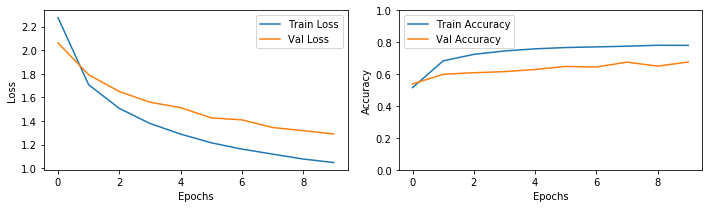

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

fig.tight_layout()
fig.show()

##### 5) Evaluation

In [16]:
Y_pred = model.predict(X_test)
print(Y_pred.shape, Y_test.shape)

(5002, 12) (5002, 12)


In [17]:
Y_pred_flatten, Y_test_flatten = np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1)
print(Y_pred_flatten.shape, Y_test_flatten.shape)

(5002,) (5002,)


                   precision    recall  f1-score   support

            lying       0.82      0.89      0.86       544
          sitting       0.53      0.45      0.49       469
         standing       0.56      0.70      0.62       435
          walking       0.63      0.48      0.54       445
          running       0.96      0.91      0.93       426
          cycling       0.94      0.83      0.88       472
   Nordic walking       0.89      0.65      0.75       405
 ascending stairs       0.36      0.62      0.46       318
descending stairs       0.33      0.16      0.22       299
  vacuum cleaning       0.79      0.77      0.78       459
          ironing       0.56      0.91      0.69       471
     rope jumping       0.91      0.37      0.53       259

         accuracy                           0.68      5002
        macro avg       0.69      0.65      0.65      5002
     weighted avg       0.70      0.68      0.67      5002



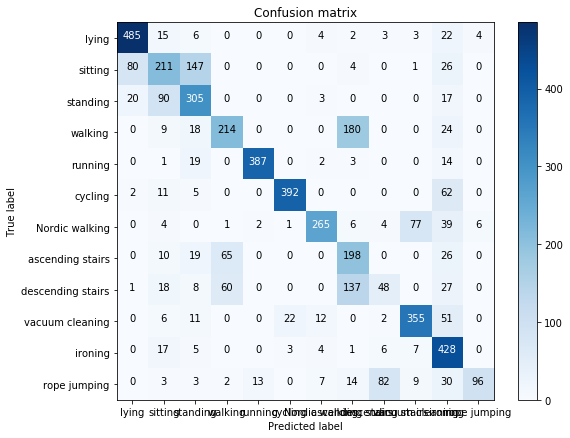

In [18]:
target_names = [label_map[label] for label in unmap_label(sorted(set(Y)))]
print(classification_report(Y_test_flatten, Y_pred_flatten, target_names=target_names))
plot_confusion_matrix(Y_test_flatten, Y_pred_flatten, target_names=target_names)

##### 6) Model Save and Load

In [19]:
save_dir = 'saved_model/simple_cnn'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(save_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/simple_cnn/assets


In [20]:
model = load_model(save_dir)

#### B. Complex CNN

##### 1) Model Definition
<img src='images/CNN for Activity Recognition.png'>

In [21]:
num_features = 3
num_latent = 100
num_kernels = 32

model = Sequential([
    Input(shape=[window_size, num_features, 1]),
    # 100 x 3 x 1
    Conv2D(num_kernels, kernel_size=(10, 1), kernel_regularizer='l2'),
    # 91 x 3 x 32
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(10, 1), kernel_regularizer='l2'),
    # 82 x 3 x 32
    ReLU(),
    MaxPool2D(pool_size=(2, 1), strides=(2, 1)),
    # 41 x 3 x 32
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(10, 1), kernel_regularizer='l2'),
    # 32 x 3 x 32
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(5, 1), kernel_regularizer='l2'),
    # 28 x 3 x 32
    ReLU(),
    MaxPool2D(pool_size=(2, 1), strides=(2, 1)),
    # 14 x 3 x 32
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(3, 1), kernel_regularizer='l2'),
    # 12 x 3 x 32
    ReLU(),
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(3, 1), kernel_regularizer='l2'),
    # 10 x 3 x 32
    ReLU(),
    MaxPool2D(pool_size=(2, 1), strides=(2, 1)),
    # 5 x 3 x 32
    BatchNormalization(),
    Conv2D(num_kernels, kernel_size=(3, 1), kernel_regularizer='l2'),
    # 3 x 3 x 32
    ReLU(),
    BatchNormalization(),
    Conv2D(num_latent, kernel_size=(3, 3), kernel_regularizer='l2'),
    # 1 x 1 x 100
    Flatten(),
    # 100
    Dense(num_classes, activation='softmax'),
    # 12
])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 91, 3, 32)         352       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 91, 3, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 91, 3, 32)         128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 82, 3, 32)         10272     
_________________________________________________________________
re_lu_5 (ReLU)               (None, 82, 3, 32)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 3, 32)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 41, 3, 32)        

##### 2) Train / Test Split

In [22]:
test_subjects = [0, 1]

test_mask = np.isin(groups, test_subjects)
train_mask = np.logical_not(test_mask)

X_train = normalize(X[train_mask][..., np.newaxis])
Y_train = to_categorical(Y[train_mask], num_classes=num_classes)

X_test = normalize(X[test_mask][..., np.newaxis])
Y_test = to_categorical(Y[test_mask], num_classes=num_classes)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(28527, 100, 3, 1) (28527, 12) (10267, 100, 3, 1) (10267, 12)


##### 3) Train Setup

In [23]:
model.compile(
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    optimizer=RMSprop(learning_rate=0.0001),
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses
    loss=CategoricalCrossentropy(),
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    metrics=['accuracy']
)

##### 4) Model Training

In [24]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10
)

Epoch 1/10
892/892 [==============================] - 10s 11ms/step - loss: 3.9451 - accuracy: 0.4390 - val_loss: 4.0128 - val_accuracy: 0.3299
Epoch 2/10
892/892 [==============================] - 10s 11ms/step - loss: 3.4147 - accuracy: 0.5153 - val_loss: 3.6472 - val_accuracy: 0.3841
Epoch 3/10
892/892 [==============================] - 10s 11ms/step - loss: 3.0703 - accuracy: 0.5300 - val_loss: 3.5812 - val_accuracy: 0.3489
Epoch 4/10
892/892 [==============================] - 9s 10ms/step - loss: 2.8110 - accuracy: 0.5407 - val_loss: 3.1482 - val_accuracy: 0.3751
Epoch 5/10
892/892 [==============================] - 9s 11ms/step - loss: 2.6039 - accuracy: 0.5486 - val_loss: 2.8703 - val_accuracy: 0.4439
Epoch 6/10
892/892 [==============================] - 9s 11ms/step - loss: 2.4308 - accuracy: 0.5539 - val_loss: 2.7299 - val_accuracy: 0.4404
Epoch 7/10
892/892 [==============================] - 9s 10ms/step - loss: 2.2941 - accuracy: 0.5608 - val_loss: 2.9677 - val_accuracy: 0.3

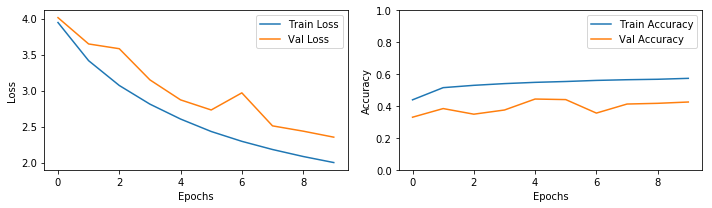

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

fig.tight_layout()
fig.show()

##### 5) Evaluation

In [26]:
Y_pred = model.predict(X_test)
print(Y_pred.shape, Y_test.shape)

(10267, 12) (10267, 12)


In [27]:
Y_pred_flatten, Y_test_flatten = np.argmax(Y_pred, axis=1), np.argmax(Y_test, axis=1)
print(Y_pred_flatten.shape, Y_test_flatten.shape)

(10267,) (10267,)


                   precision    recall  f1-score   support

            lying       0.62      0.91      0.74      1012
          sitting       0.22      0.03      0.06       915
         standing       0.40      0.00      0.01       947
          walking       0.43      0.61      0.51      1095
          running       0.86      0.86      0.86       611
          cycling       0.70      0.55      0.61       974
   Nordic walking       0.39      0.48      0.43       999
 ascending stairs       0.39      0.07      0.12       665
descending stairs       0.15      0.04      0.06       603
  vacuum cleaning       0.38      0.39      0.39       872
          ironing       0.21      0.63      0.31      1049
     rope jumping       0.94      0.25      0.39       525

         accuracy                           0.43     10267
        macro avg       0.47      0.40      0.37     10267
     weighted avg       0.45      0.43      0.38     10267



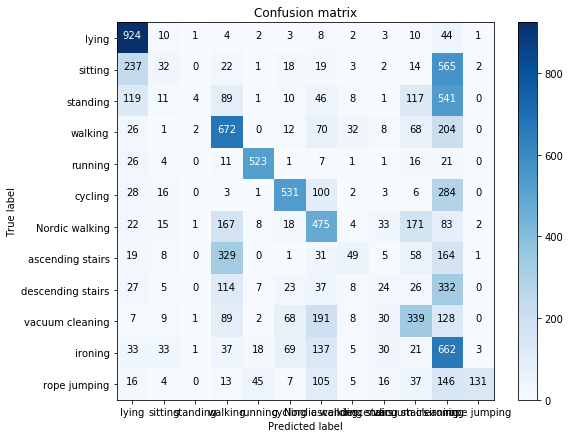

In [28]:
target_names = [label_map[label] for label in unmap_label(sorted(set(Y)))]
print(classification_report(Y_test_flatten, Y_pred_flatten, target_names=target_names))
plot_confusion_matrix(Y_test_flatten, Y_pred_flatten, target_names=target_names)

##### 6) Model Save and Load

In [ ]:
save_dir = 'saved_model/cnn'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(save_dir)

In [ ]:
model = load_model(save_dir)